### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Progetto AN2DL/1_OutlierRemoval

Mounted at /gdrive
/gdrive/My Drive/Progetto AN2DL/1_OutlierRemoval


### Import libraries

In [2]:
# Hide warnings
seed  = 42
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)

2.14.0


In [4]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

### Create Ad-hoc model

In [5]:
# Create MobileNetV2 model with specified settings
mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

9406464/9406464 [==============================] - 0s 0us/step


### Load and process the dataset

In [6]:
# Load data
data = np.load('../public_data.npz', allow_pickle=True)

# Normalize image pixel values to a float range [0, 1]
images = data['data']/255

# Save labels in a new list
labels = data['labels']

# Print data shape
print(images.shape, labels.shape)

(5200, 96, 96, 3) (5200,)


In [7]:
num_img = len(images)   # Lenght of the initial dataset
index = 701             # Image index associated with 'Troll'

# Plot image
# plt.imshow(images[index])
# plt.show()

# Compute image distance from 'Troll'
image = np.expand_dims(images[index],axis=0)
image_features = mobile.predict(image,verbose=0)
dataset_features = mobile.predict(images,batch_size=32,verbose=0)
troll_distances = np.mean(np.square(dataset_features - image_features),axis=-1)

index = 58              # Image index associated with 'Shrek'

# Plot image
# plt.imshow(images[index])
# plt.show()

# Compute image distance from 'Shrek'
image = np.expand_dims(images[index],axis=0)
image_features = mobile.predict(image,verbose=0)
dataset_features = mobile.predict(images,batch_size=32,verbose=0)
shrek_distances = np.mean(np.square(dataset_features - image_features),axis=-1)

In [8]:
# Create list with the indices to be removed from the starting data
indices = []
troll_count = 0
shrek_count = 0
for i in range(num_img):
  if(troll_distances[i] < 0.1):
    troll_count = troll_count + 1
    indices.append(i)
  if(shrek_distances[i] < 0.1):
    shrek_count = shrek_count + 1
    indices.append(i)
print("Shrek indices: ", shrek_count)
print("Troll indices: ", shrek_count)

Shrek indices:  98
Troll indices:  98


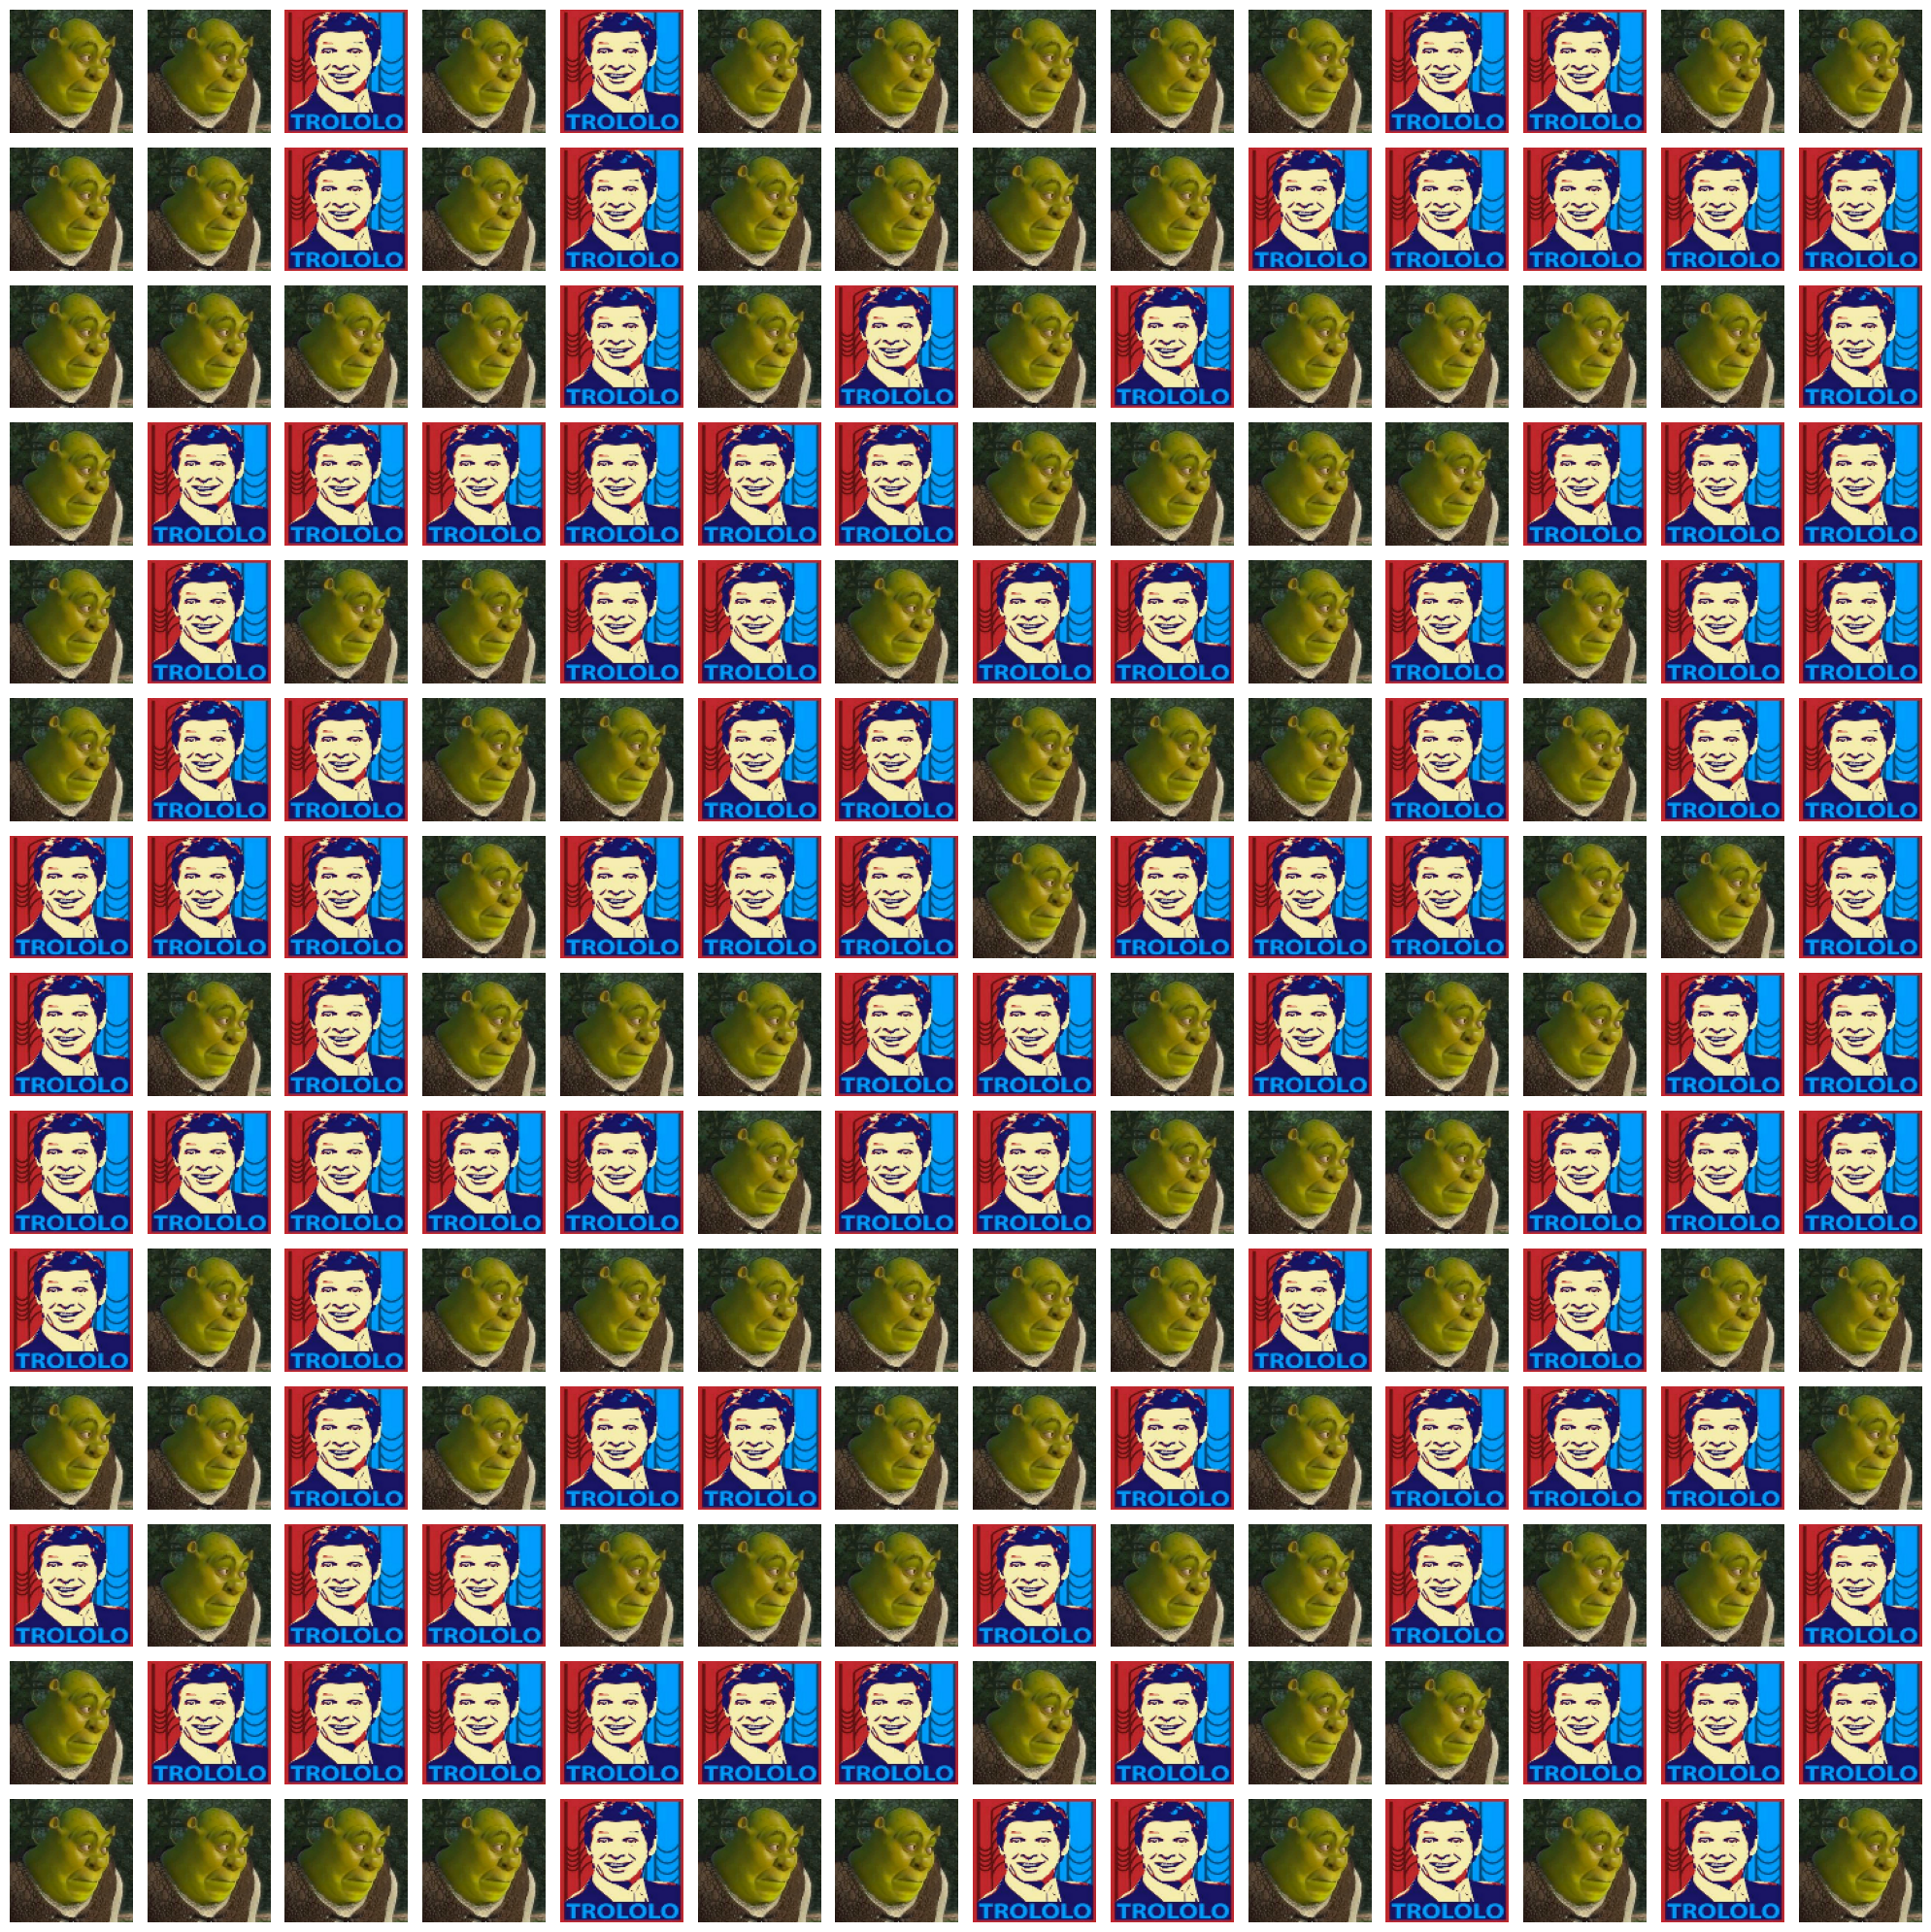

In [9]:
# Plot images to be removed
num_img = len(indices)
fig, axes = plt.subplots(14, num_img//14, figsize=(20, 20))
for i in range(num_img):
    ax = axes[i%14, i%num_img//14]
    ax.imshow(np.clip(images[indices[i]], 0, 255))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()

In [10]:
# Create new dataset with normalised value in a float range [0, 1]
new_images = []
new_labels = []
j = 0
for i in range(len(images)):
  if i not in indices:
    new_images.append(images[i])
    new_labels.append(labels[i])
print(f"Number of images in the new dataset: {len(new_images)}")
print(f"Number of labels in the new dataset: {len(new_labels)}")

np.savez_compressed('../clean_data', data=new_images, labels=new_labels)

Number of images in the new dataset: 5004
Number of labels in the new dataset: 5004
